# Statistical Analysis of Weather Data and Disease Prevalence in Hong Kong

## Notebook Setup

In [1]:
# Load required libraries
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO
from scipy import stats
from datetime import datetime
from IPython.display import Image
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, classification_report, roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Weather Data Preparation

In [2]:
# Load weather data
# daily mean temperature
mean_temp_raw = pd.read_csv("data/CLMTEMP_HKO_.csv",
                            names=["Year", "Month", "Day", "Temp", "Complete"],
                            skiprows=3, skipfooter=3, na_values="***", dtype={"Temp": float}, engine="python")
# daily minimum temperature
min_temp_raw = pd.read_csv("data/CLMMINT_HKO_.csv",
                           names=["Year", "Month", "Day", "Temp", "Complete"],
                           skiprows=3, skipfooter=3, na_values="***", dtype={"Temp": float}, engine="python")
# daily maximum temperature
max_temp_raw = pd.read_csv("data/CLMMAXT_HKO_.csv",
                           names=["Year", "Month", "Day", "Temp", "Complete"],
                           skiprows=3, skipfooter=3, na_values="***", dtype={"Temp": float}, engine="python")
# daily rainfall
rainfall_raw = pd.read_csv("data/daily_HKO_RF_ALL.csv",
                           names=["Year", "Month", "Day", "Rf", "Complete"],
                           skiprows=3, skipfooter=4, na_values=["Trace", "***"], dtype={"Rf": float}, engine="python")
# daily humidity
humidity_raw = pd.read_csv("data/daily_HKO_RH_ALL.csv",
                           names=["Year", "Month", "Day", "Hum", "Complete"],
                           skiprows=3, skipfooter=3, na_values="***", dtype ={"Hum": float}, engine="python")


# Function to clean the data
def cleanData(df, start_year=2010, end_year=2024, start_date="2010-01-01", end_date="2024-12-31"):
    df = df[(df["Year"] >= start_year) & (df["Year"] <= end_year)] # filter for the sample period
    df = df.drop(columns=["Year", "Month", "Day", "Complete"])
    df = df.set_index(pd.date_range(start=start_date, end=end_date))
    df = df.fillna(0)
    return df

In [3]:
mean_temp = cleanData(mean_temp_raw)
min_temp = cleanData(min_temp_raw)
max_temp = cleanData(max_temp_raw)
rainfall = cleanData(rainfall_raw)
humidity = cleanData(humidity_raw)

# Inspect data
print(mean_temp.head(3), "\n")
print(min_temp.head(3), "\n")
print(max_temp.head(3), "\n")
print(rainfall.head(3), "\n")
print(humidity.head(3), "\n")

            Temp
2010-01-01  16.2
2010-01-02  17.4
2010-01-03  17.0 

            Temp
2010-01-01  15.0
2010-01-02  16.1
2010-01-03  15.8 

            Temp
2010-01-01  18.1
2010-01-02  20.0
2010-01-03  18.3 

             Rf
2010-01-01  0.0
2010-01-02  5.2
2010-01-03  3.5 

             Hum
2010-01-01  73.0
2010-01-02  88.0
2010-01-03  87.0 



In [4]:
# Create weather data frame
weather = pd.concat([min_temp, mean_temp, max_temp, rainfall, humidity], axis=1)
weather.columns = ["Min_Temp", "Mean_Temp", "Max_Temp", "Rainfall", "Humidity"]
print(weather.head(3), "\n")
print(weather.tail(3), "\n")

print(weather.shape)

            Min_Temp  Mean_Temp  Max_Temp  Rainfall  Humidity
2010-01-01      15.0       16.2      18.1       0.0      73.0
2010-01-02      16.1       17.4      20.0       5.2      88.0
2010-01-03      15.8       17.0      18.3       3.5      87.0 

            Min_Temp  Mean_Temp  Max_Temp  Rainfall  Humidity
2024-12-29      13.3       15.4      17.4       0.0      57.0
2024-12-30      14.3       17.7      20.4       0.0      63.0
2024-12-31      17.6       19.8      22.6       0.0      55.0 

(5479, 5)


In [5]:
# Aggregate daily data into monthly data
weather_monthly = weather.resample("ME").mean()
weather_monthly.index = weather_monthly.index.to_period("M")

# Inspect data
print(weather_monthly.head(3), "\n")
print(weather_monthly.tail(3), "\n")

          Min_Temp  Mean_Temp   Max_Temp  Rainfall   Humidity
2010-01  15.164516  16.848387  18.987097  0.793548  80.000000
2010-02  16.335714  17.857143  19.739286  4.039286  88.071429
2010-03  18.109677  20.151613  23.051613  0.564516  80.000000 

          Min_Temp  Mean_Temp   Max_Temp  Rainfall   Humidity
2024-10  25.409677  27.341935  30.274194  0.364516  65.483871
2024-11  21.316667  23.023333  25.283333  6.470000  70.166667
2024-12  16.493548  18.525806  20.832258  0.000000  60.064516 



## Weather Data Visualization

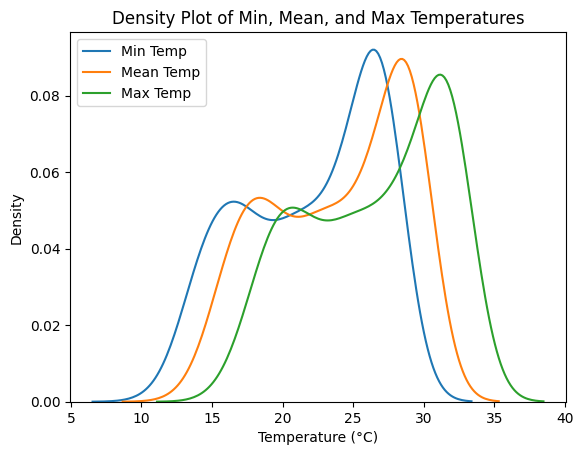

In [6]:
# Plot temperature data
sns.kdeplot(weather_monthly["Min_Temp"], label="Min Temp")
sns.kdeplot(weather_monthly["Mean_Temp"], label="Mean Temp")
sns.kdeplot(weather_monthly["Max_Temp"], label="Max Temp")
plt.xlabel("Temperature (°C)")
plt.ylabel("Density")
plt.title("Density Plot of Min, Mean, and Max Temperatures")
plt.legend()
plt.show()

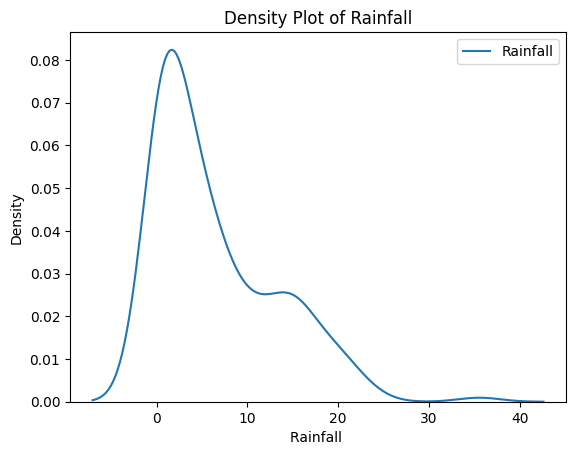

In [7]:
# Plot rainfall data
sns.kdeplot(weather_monthly["Rainfall"], label="Rainfall")
plt.xlabel("Rainfall ")
plt.ylabel("Density")
plt.title("Density Plot of Rainfall")
plt.legend()
plt.show()

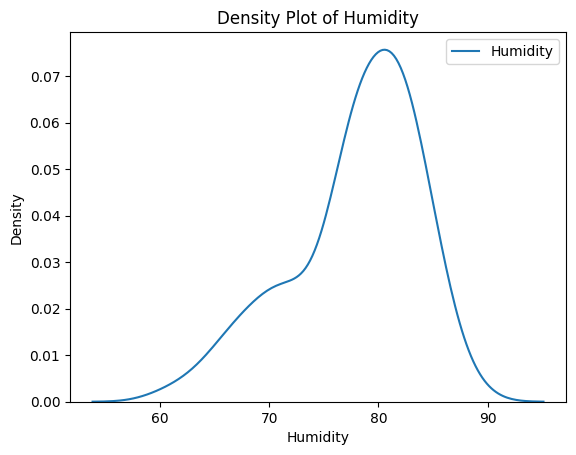

In [8]:
# Plot humidity data
sns.kdeplot(weather_monthly["Humidity"], label="Humidity")
plt.xlabel("Humidity")
plt.ylabel("Density")
plt.title("Density Plot of Humidity")
plt.legend()
plt.show()

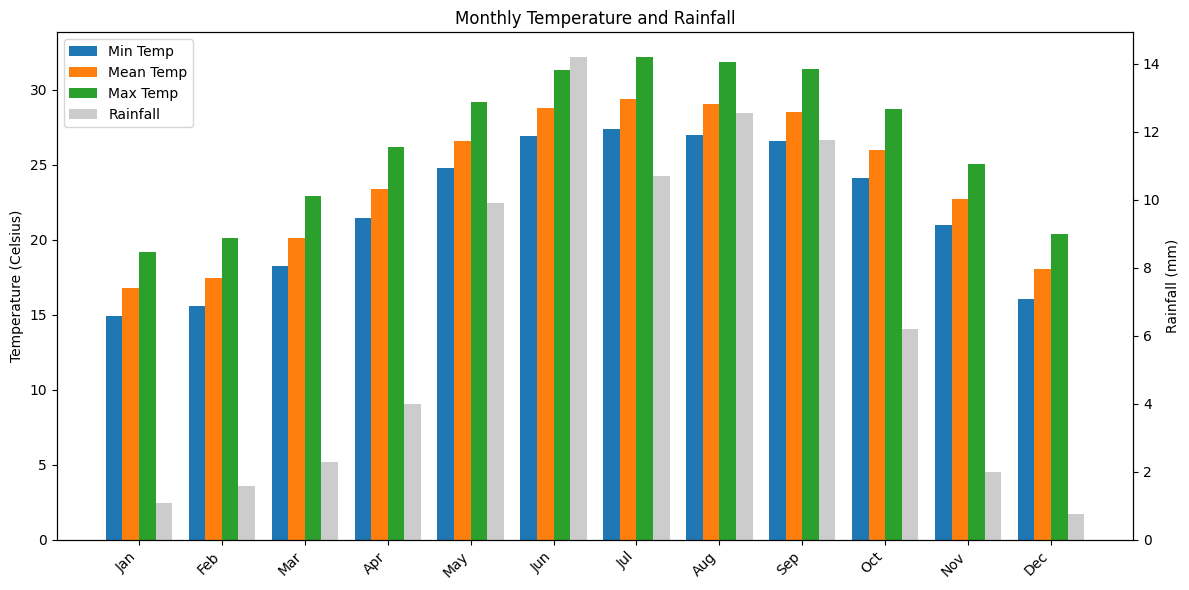

In [9]:
# Inspect seasonal patterns in temperature and rainfall
weather_seasonal = weather.groupby(weather.index.month).mean()

# Plot bar chart for seasonal data
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
fig, ax1 = plt.subplots(figsize=(12, 6))
width = 0.2

# Temperatures on the left y-axis
ax1.bar(np.arange(len(months)), weather_seasonal["Min_Temp"], width, label="Min Temp")
ax1.bar(np.arange(len(months)) + width, weather_seasonal["Mean_Temp"], width, label="Mean Temp")
ax1.bar(np.arange(len(months)) + 2 * width, weather_seasonal["Max_Temp"], width, label="Max Temp")
ax1.set_ylabel("Temperature (Celsius)")

# Rainfall on the right y-axis
ax2 = ax1.twinx()
ax2.bar(np.arange(len(months)) + 3 * width, weather_seasonal["Rainfall"], width, label="Rainfall", color="gray", alpha=0.4)
ax2.set_ylabel("Rainfall (mm)")

ax1.set_xticks(np.arange(len(months)) + 1.5 * width)
ax1.set_xticklabels(months, rotation=45, ha="right")
plt.title("Monthly Temperature and Rainfall")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper left")

plt.tight_layout()
plt.show()

## Disease Data Preparation

In [10]:
# Load disease data
disease_df = pd.read_excel("data/2015-2024 Disease.xlsx", sheet_name="2024")

# Process the data
disease_df.columns = disease_df.columns.str.strip()
disease_df = disease_df[disease_df["Disease"].notna()]
disease_df = disease_df.drop(columns=[col for col in disease_df.columns if "Total" in col or "Grand" in col], errors="ignore")

# Melt to long format
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
disease_long = pd.melt(disease_df, id_vars=["Disease", "Year"], value_vars=months, var_name="Month", value_name="Cases")

# Convert month names to numbers
month_map = {month: i+1 for i, month in enumerate(months)}
disease_long["Month"] = disease_long["Month"].map(month_map)

# Pivot the disease data to create columns for each disease
disease_pivot = disease_long.pivot(index=["Year", "Month"], columns="Disease", values="Cases").reset_index()

# Merge disease data and weather data
weather_monthly["Year"] = weather_monthly.index.year
weather_monthly["Month"] = weather_monthly.index.month
merged = disease_pivot.merge(weather_monthly, on=["Year", "Month"], how="left")
merged = merged.fillna(0)

# Convert all disease columns to numeric, filling NaN with 0
disease_columns = [col for col in merged.columns if col not in ["Year", "Month", "Mean_Temp", "Min_Temp", "Max_Temp", "Rainfall", "Humidity"]]
for col in disease_columns:
    merged[col] = pd.to_numeric(merged[col], errors="coerce").fillna(0)

print("\nFinal dataset shape:", merged.shape)
print("\nColumns:", merged.columns.tolist())
print("\nSample data:\n", merged.head(15))


Final dataset shape: (120, 71)

Columns: ['Year', 'Month', 'Acute poliomyelitis', 'Amoebic dysentery', 'Anthrax', 'Bacillary dysentery', 'Botulism', 'Chickenpox', 'Chikungunya fever', 'Cholera', 'Community-associated methicillin-resistant Staphylococcus aureus infection', 'Coronavirus disease 2019 (COVID-19)', 'Creutzfeldt-Jakob disease', 'Dengue fever', 'Diphtheria', 'Enterovirus 71 infection', 'Food poisoning - Outbreaks', 'Food poisoning - Persons affected', 'Haemophilus influenzae type b infection (invasive)', 'Hantavirus infection', 'Invasive pneumococcal disease', 'Japanese encephalitis', "Legionnaires' disease", 'Leprosy', 'Leptospirosis', 'Listeriosis', 'Malaria', 'Measles', 'Melioidosis', 'Meningococcal infection (invasive)', 'Middle East Respiratory Syndrome', 'Mpox (Monkeypox)', 'Mumps', 'Novel influenza A infection - Influenza A (H5)', 'Novel influenza A infection - Influenza A (H7)', 'Novel influenza A infection - Others', 'Paratyphoid fever', 'Plague', 'Psittacosis', 'Q 

<ipython-input-10-d25fd9f47a98>:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged = merged.fillna(0)


In [11]:
# Save to Excel
merged.to_excel("processed_disease_weather_data.xlsx", index=False)
print("- processed_disease_weather_data.xlsx")

- processed_disease_weather_data.xlsx


## Disease and Weather Data Analysis

### Logistic Regression

In [12]:
# Features: Weather parameters
features = ["Mean_Temp", "Rainfall", "Humidity"]

# Target: All disease columns
diseases = [col for col in merged.columns if col not in
 ["Year", "Month", "Mean_Temp","Rainfall", "Humidity"]]

# Dictionary to store models and metrics
models = {}
performance = {}

for disease in diseases:
    # Skip diseases with no cases or all cases
    if merged[disease].sum() == 0:
        print(f"Skipping {disease} (no cases)")
        continue

    if merged[disease].sum() == len(merged):
        print(f"Skipping {disease} (all cases are positive)")
        continue

    # Create binary target
    y = (merged[disease] > 0).astype(int)
    X = merged[features]

    # Check class distribution
    class_counts = y.value_counts()
    if len(class_counts) < 2:
        print(f"Skipping {disease} (only one class present)")
        continue

    # Split data with stratification to maintain class distribution
    try:
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.2, random_state=42, stratify=y)

        # Train model
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train, y_train)

        # Predict and evaluate
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, zero_division=0)
        if len(np.unique(y_test)) >= 2:
            roc_auc = roc_auc_score(y_test, y_proba)
        else:
            roc_auc = None

        # Store results
        models[disease] = model
        performance[disease] = {
            "accuracy": acc,
            "f1_score": f1,
            "roc_auc": roc_auc,
            "classification_report": report
            }

        # Print summary
        print(f"\n--- {disease} Model ---")
        print(f"Accuracy: {acc:.2f}")
        print(f"F1 Score: {f1:.2f}")
        if roc_auc is not None:
            print(f"ROC-AUC: {roc_auc:.2f}")
        else:
            print("ROC-AUC: Not computable (only one class present)")
        print("Class Distribution (Test Set):")
        print(y_test.value_counts())
        print("\nClassification Report:")
        print(report)

    except ValueError as e:
        print(f"Error processing {disease}: {str(e)}")
        continue

Skipping Acute poliomyelitis (no cases)

--- Amoebic dysentery Model ---
Accuracy: 0.42
F1 Score: 0.42
ROC-AUC: 0.37
Class Distribution (Test Set):
Amoebic dysentery
1    12
0    12
Name: count, dtype: int64

Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.42      0.42        12
           1       0.42      0.42      0.42        12

    accuracy                           0.42        24
   macro avg       0.42      0.42      0.42        24
weighted avg       0.42      0.42      0.42        24

Skipping Anthrax (no cases)

--- Bacillary dysentery Model ---
Accuracy: 0.79
F1 Score: 0.88
ROC-AUC: 0.49
Class Distribution (Test Set):
Bacillary dysentery
1    19
0     5
Name: count, dtype: int64

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.79      1.00      0.88        19

    accuracy                           0.79        24

In [13]:
# Calculate average accuracy and F1 scores
accuracy_scores = {disease: metrics['accuracy'] for disease, metrics in performance.items()}
f1_scores_values = {disease: metrics['f1_score'] for disease, metrics in performance.items() if 'f1_score' in metrics}
roc_auc_scores = {disease: metrics['roc_auc'] for disease, metrics in performance.items()
                  if metrics['roc_auc'] is not None}

average_accuracy = np.mean(list(accuracy_scores.values()))
average_f1 = np.mean(list(f1_scores_values.values())) if f1_scores_values else None
average_roc_auc = np.mean(list(roc_auc_scores.values())) if roc_auc_scores else None

# Identify best and worst models based on accuracy
best_disease = max(accuracy_scores, key=accuracy_scores.get)
worst_disease = min(accuracy_scores, key=accuracy_scores.get)

# Print results
print(f"\nAverage Accuracy: {average_accuracy:.2f}")
if average_f1 is not None:
    print(f"Average F1 Score: {average_f1:.2f}")
if average_roc_auc is not None:
    print(f"Average ROC-AUC: {average_roc_auc:.2f}")
print(f"Best Model: {best_disease} with Accuracy: {accuracy_scores[best_disease]:.2f}")
print(f"Worst Model: {worst_disease} with Accuracy: {accuracy_scores[worst_disease]:.2f}")


Average Accuracy: 0.76
Average F1 Score: 0.40
Average ROC-AUC: 0.53
Best Model: Legionnaires' disease with Accuracy: 1.00
Worst Model: Measles with Accuracy: 0.38


In [14]:
# Dictionary to store weather-disease relationships for every one unit metric
weather_relations = {}

for disease, model in models.items():
    # Get coefficients and pair with feature names
    coefficients = model.coef_[0]
    feature_effects = dict(zip(features, coefficients))

    # Sort features by absolute impact (most influential first)
    sorted_effects = sorted(
        feature_effects.items(),
        key=lambda x: abs(x[1]),
        reverse=True
    )

    weather_relations[disease] = sorted_effects

# Print results
print("\n=== Weather-Disease Relationships ===")
for disease, effects in weather_relations.items():
    print(f"\n{disease}:")
    for feature, coef in effects:
        direction = "↑ Increases risk" if coef > 0 else "↓ Decreases risk"
        print(f"  - {feature}: {coef:.2f} ({direction})")


=== Weather-Disease Relationships ===

Amoebic dysentery:
  - Mean_Temp: 0.03 (↑ Increases risk)
  - Humidity: 0.02 (↑ Increases risk)
  - Rainfall: -0.01 (↓ Decreases risk)

Bacillary dysentery:
  - Rainfall: -0.04 (↓ Decreases risk)
  - Humidity: -0.02 (↓ Decreases risk)
  - Mean_Temp: 0.02 (↑ Increases risk)

Botulism:
  - Mean_Temp: 0.13 (↑ Increases risk)
  - Humidity: -0.08 (↓ Decreases risk)
  - Rainfall: 0.02 (↑ Increases risk)

Chikungunya fever:
  - Mean_Temp: 0.10 (↑ Increases risk)
  - Rainfall: 0.00 (↑ Increases risk)
  - Humidity: 0.00 (↑ Increases risk)

Cholera:
  - Mean_Temp: 0.27 (↑ Increases risk)
  - Humidity: 0.21 (↑ Increases risk)
  - Rainfall: -0.06 (↓ Decreases risk)

Coronavirus disease 2019 (COVID-19):
  - Humidity: -0.11 (↓ Decreases risk)
  - Mean_Temp: 0.05 (↑ Increases risk)
  - Rainfall: 0.04 (↑ Increases risk)

Creutzfeldt-Jakob disease:
  - Mean_Temp: 0.09 (↑ Increases risk)
  - Humidity: -0.07 (↓ Decreases risk)
  - Rainfall: -0.00 (↓ Decreases risk)

### Hypothesis Testing

In [15]:
# Rainfall
# To prevent changes to the original dataset
merged_htr = merged.copy()

# Set a threshold for high and low rainfall
rainfall_threshold = merged_htr["Rainfall"].median()
merged_htr["Rainfall_Category"] = ["High" if x > rainfall_threshold else "Low" for x in merged_htr["Rainfall"]]

diseases = [col for col in merged_htr.columns if col not in
 ["Year", "Month", "Mean_Temp", "Min_Temp", "Max_Temp", "Rainfall", "Rainfall_Category", "Humidity"]]

# Initialize a results list for rainfall
rainfall_results = []

# Loop through each disease and perform t-test
for disease in diseases:
    high_rainfall_cases = merged_htr[merged_htr["Rainfall_Category"] == 'High'][disease].dropna()
    low_rainfall_cases = merged_htr[merged_htr["Rainfall_Category"] == 'Low'][disease].dropna()

    # Perform the t-test
    t_stat, p_value = stats.ttest_ind(high_rainfall_cases, low_rainfall_cases, equal_var=False)

    # Append results to the list
    rainfall_results.append({"Disease": disease, "T-statistic": t_stat, "P-value": p_value})

# Convert results to DataFrame for better visualization
rainfall_results_df = pd.DataFrame(rainfall_results)

# Sort the results by T-statistic in descending order
sorted_rainfall_results_df = rainfall_results_df.sort_values(by="T-statistic", ascending=False)

# Display the sorted results
print("\nHypothesis Test Results for Rainfall:")
print(sorted_rainfall_results_df)


Hypothesis Test Results for Rainfall:
                                              Disease  T-statistic  \
20                              Legionnaires' disease     6.463693   
50  Typhus and other rickettsial diseases - Scrub ...     3.583464   
7                                             Cholera     3.012793   
34                                  Paratyphoid fever     2.732349   
19                              Japanese encephalitis     2.653408   
..                                                ...          ...   
45                                           Smallpox          NaN   
54                           Viral haemorrhagic fever          NaN   
58                                Viral hepatitis - D          NaN   
60                          West Nile Virus Infection          NaN   
62                                       Yellow fever          NaN   

         P-value  
20  4.036458e-09  
50  5.534793e-04  
7   3.809291e-03  
34  7.272797e-03  
19  9.914707e-03  
..    

In [16]:
# Humidity
# To prevent changes to the original dataset
merged_hth = merged.copy()

# Set threshold for high and low humidity
humidity_threshold = merged_hth["Humidity"].median()
merged_hth["Humidity_Category"] = ["High" if x > humidity_threshold else "Low" for x in merged_hth["Humidity"]]

diseases = [col for col in merged_hth.columns if col not in
 ["Year", "Month", "Mean_Temp", "Min_Temp", "Max_Temp", "Rainfall", "Humidity", "Humidity_Category"]]

# Initialize results list for humidity
humidity_results = []

# Loop through each disease and perform t-test
for disease in diseases:
    high_humidity_cases = merged_hth[merged_hth["Humidity_Category"] == "High"][disease].dropna()
    low_humidity_cases = merged_hth[merged_hth["Humidity_Category"] == "Low"][disease].dropna()

    # Perform the t-test
    t_stat, p_value = stats.ttest_ind(high_humidity_cases, low_humidity_cases, equal_var=False)

    # Append results to the list
    humidity_results.append({"Disease": disease, "T-statistic": t_stat, "P-value": p_value})

# Convert results to DataFrame for better visualization
humidity_results_df = pd.DataFrame(humidity_results)

# Sort the results by T-statistic in descending order
sorted_humidity_results_df = humidity_results_df.sort_values(by="T-statistic", ascending=False)

# Display the sorted results for humidity
print("\nHypothesis Test Results for Humidity:")
print(sorted_humidity_results_df)


Hypothesis Test Results for Humidity:
                      Disease  T-statistic   P-value
34          Paratyphoid fever     2.732349  0.007289
30                      Mumps     2.665804  0.008799
19      Japanese encephalitis     2.653408  0.009915
48               Tuberculosis     2.479853  0.014603
37                    Q fever     2.475857  0.015276
..                        ...          ...       ...
45                   Smallpox          NaN       NaN
54   Viral haemorrhagic fever          NaN       NaN
58        Viral hepatitis - D          NaN       NaN
60  West Nile Virus Infection          NaN       NaN
62               Yellow fever          NaN       NaN

[64 rows x 3 columns]


In [17]:
# Mean Temperature
# To prevent changes to the original dataset
merged_htt = merged.copy()

# Set threshold for high and low mean temperature
mean_temp_threshold = merged_htt["Mean_Temp"].median()
merged_htt["Mean_Temp_Category"] = ["High" if x > mean_temp_threshold else "Low" for x in merged_htt["Mean_Temp"]]

# Initialize results list for mean temperature
mean_temp_results = []

# Loop through each disease and perform t-test
for disease in disease_columns:
    high_temp_cases = merged_htt[merged_htt["Mean_Temp_Category"] == "High"][disease].dropna()
    low_temp_cases = merged_htt[merged_htt["Mean_Temp_Category"] == "Low"][disease].dropna()

    # Perform the t-test
    t_stat, p_value = stats.ttest_ind(high_temp_cases, low_temp_cases, equal_var=False)

    # Append results to the list
    mean_temp_results.append({"Disease": disease, "T-statistic": t_stat, "P-value": p_value})

# Convert results to DataFrame for better visualization
mean_temp_results_df = pd.DataFrame(mean_temp_results)

# Sort the results by T-statistic in descending order
sorted_mean_temp_results_df = mean_temp_results_df.sort_values(by="T-statistic", ascending=False)

# Display the sorted results for mean temperature
print("\nHypothesis Test Results for Mean Temperature:")
print(sorted_mean_temp_results_df)


Hypothesis Test Results for Mean Temperature:
                                              Disease  T-statistic  \
20                              Legionnaires' disease     6.463693   
50  Typhus and other rickettsial diseases - Scrub ...     4.329485   
11                                       Dengue fever     3.362688   
19                              Japanese encephalitis     3.226727   
7                                             Cholera     3.012793   
..                                                ...          ...   
45                                           Smallpox          NaN   
54                           Viral haemorrhagic fever          NaN   
58                                Viral hepatitis - D          NaN   
60                          West Nile Virus Infection          NaN   
62                                       Yellow fever          NaN   

         P-value  
20  3.074236e-09  
50  3.911700e-05  
11  1.128085e-03  
19  2.044883e-03  
7   3.809291e-03 

<ipython-input-18-8be4d19b365e>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


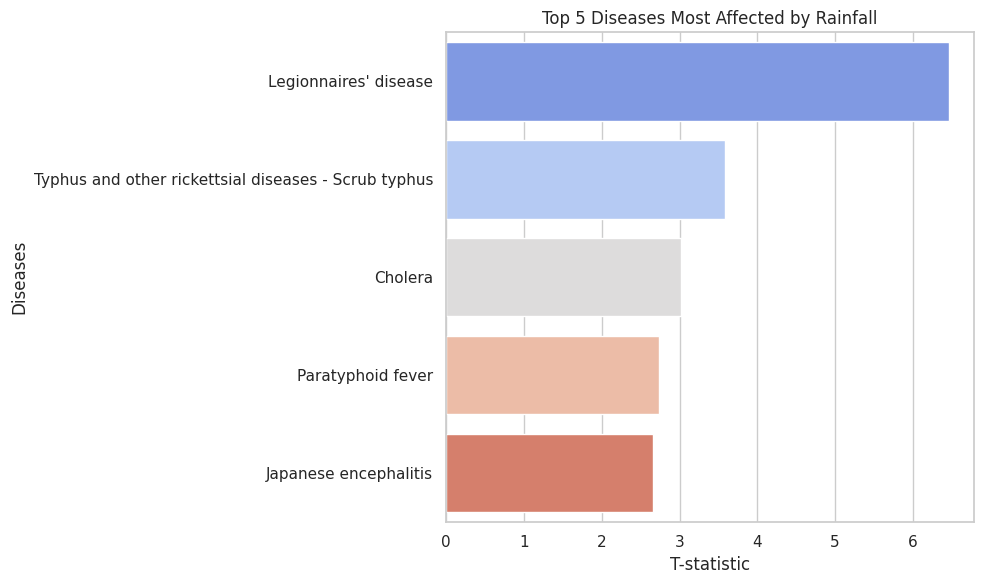

<ipython-input-18-8be4d19b365e>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


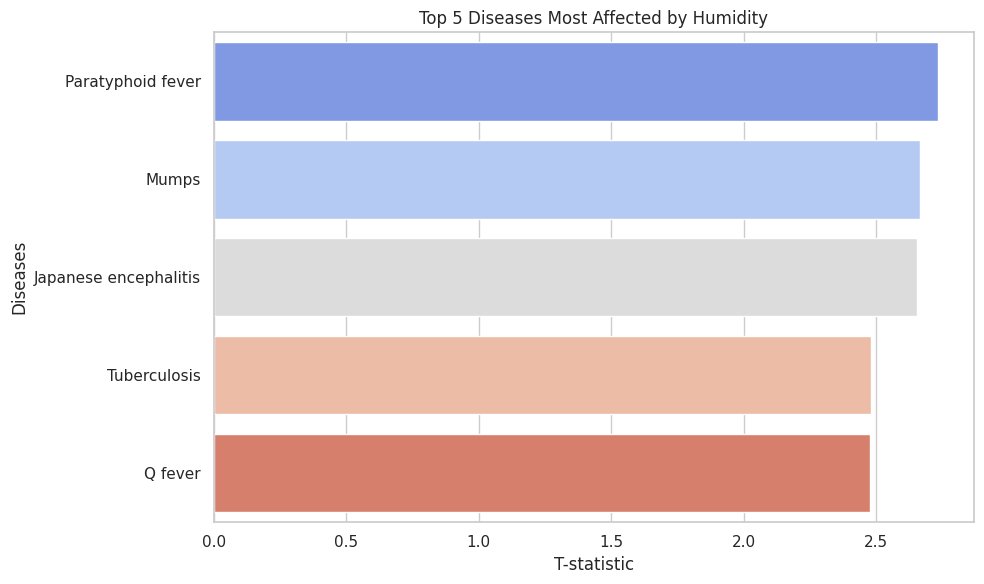

<ipython-input-18-8be4d19b365e>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


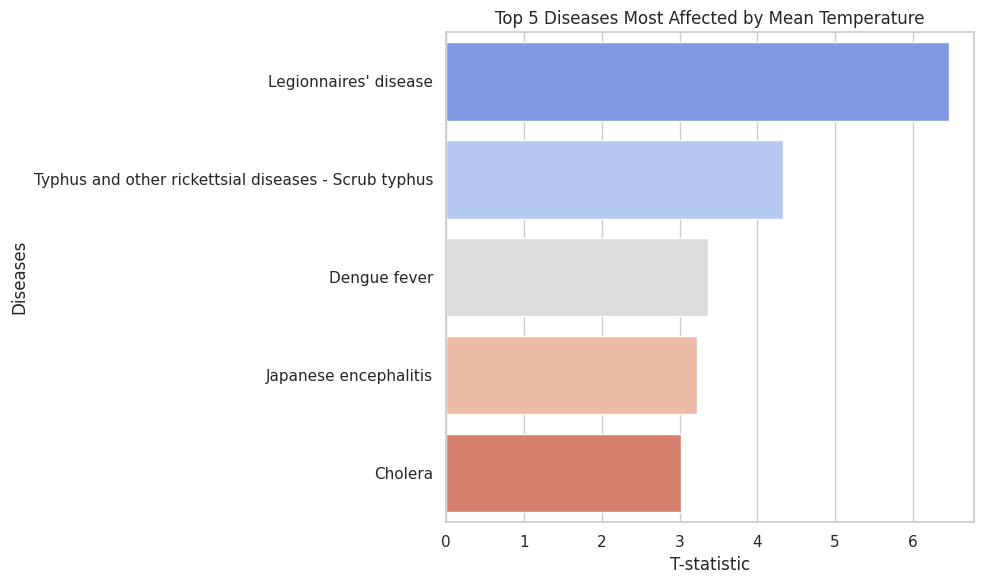

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Optional: Set a style for consistency
sns.set(style="whitegrid")

# Plot function
def plot_top_diseases(df, variable_name, top_n=5):
    top_df = df.dropna().nlargest(top_n, 'T-statistic')
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        x='T-statistic',
        y='Disease',
        data=top_df,
        palette="coolwarm"
    )
    plt.title(f'Top {top_n} Diseases Most Affected by {variable_name}')
    plt.xlabel('T-statistic')
    plt.ylabel('Diseases')
    plt.tight_layout()
    plt.show()

# Apply to each variable
plot_top_diseases(sorted_rainfall_results_df, "Rainfall")
plot_top_diseases(sorted_humidity_results_df, "Humidity")
plot_top_diseases(sorted_mean_temp_results_df, "Mean Temperature")


<ipython-input-19-1d6a5004e98c>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


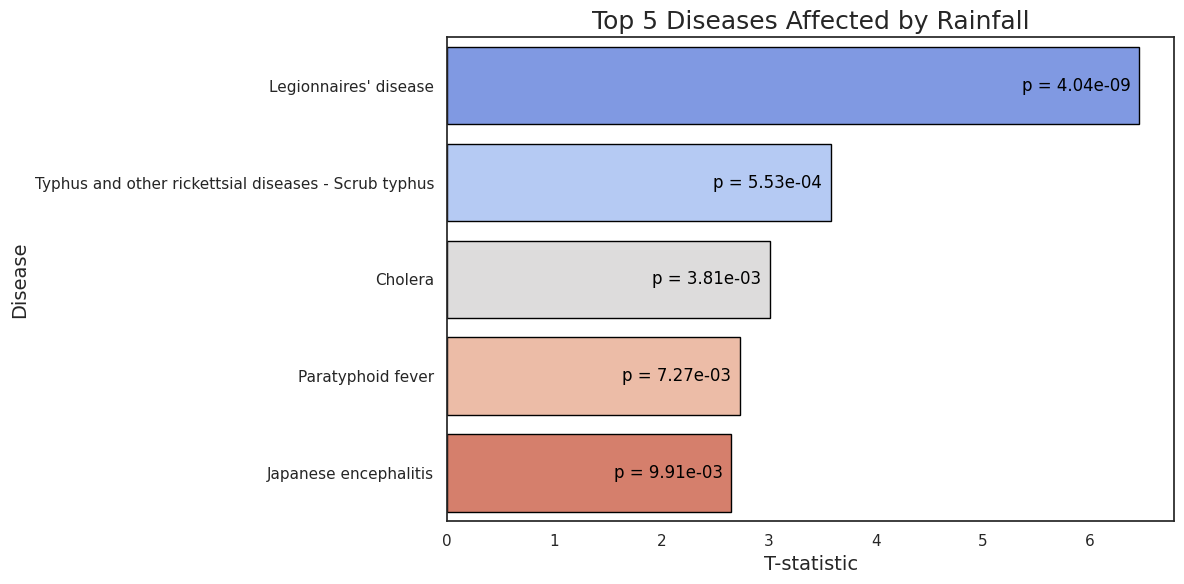

<ipython-input-19-1d6a5004e98c>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


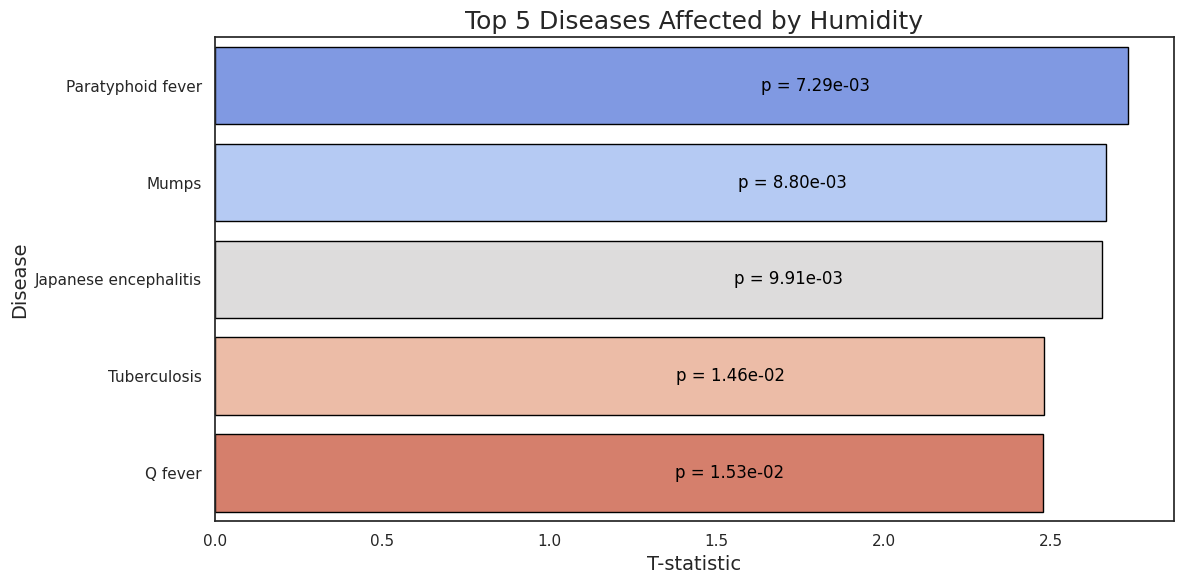

<ipython-input-19-1d6a5004e98c>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


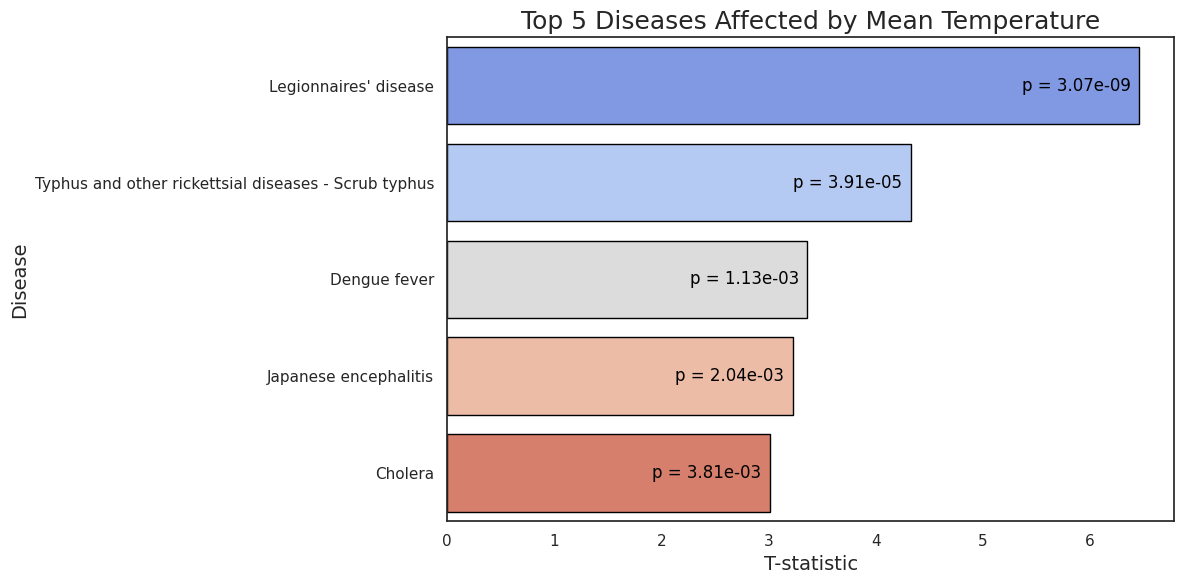

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white", palette="Set2")

def plot_top_diseases(df, variable_name, top_n=5):
    # Prepare top N rows
    top_df = df.dropna().nlargest(top_n, 'T-statistic').reset_index(drop=True)

    # Initialize the plot
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        x='T-statistic',
        y='Disease',
        data=top_df,
        palette="coolwarm",
        edgecolor='black'
    )

    # Titles and axis labels
    plt.title(f'Top {top_n} Diseases Affected by {variable_name}', fontsize=18)
    plt.xlabel('T-statistic', fontsize=14)
    plt.ylabel('Disease', fontsize=14)

    # Annotate p-values on the bars
    for i, (t, p) in enumerate(zip(top_df["T-statistic"], top_df["P-value"])):
        ax.text(
            t - 1.1,  # offset slightly to the right of the bar
            i,        # this is the y-tick position in the plot
            f"p = {p:.2e}",
            va='center',
            ha='left',
            fontsize=12,
            color='black'
        )

    plt.tight_layout()
    plt.show()

# Call function on all 3 weather variables
plot_top_diseases(sorted_rainfall_results_df, "Rainfall")
plot_top_diseases(sorted_humidity_results_df, "Humidity")
plot_top_diseases(sorted_mean_temp_results_df, "Mean Temperature")


<ipython-input-20-9010eeea524f>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


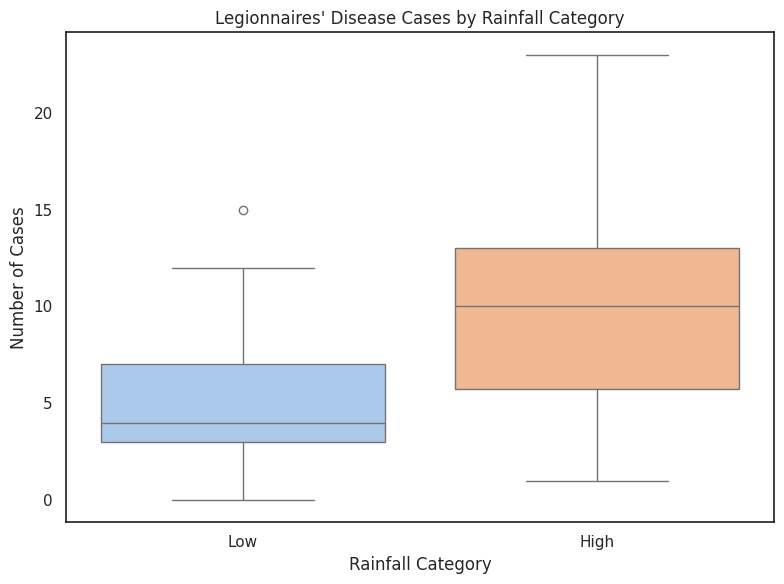

In [20]:
# Example: Legionnaires' Disease vs. Rainfall Category
import seaborn as sns

# You already have `merged_htr` from rainfall section
plt.figure(figsize=(8, 6))
sns.boxplot(
    x="Rainfall_Category",
    y="Legionnaires' disease",
    data=merged_htr,
    palette="pastel"
)
plt.title("Legionnaires' Disease Cases by Rainfall Category")
plt.xlabel("Rainfall Category")
plt.ylabel("Number of Cases")
plt.tight_layout()
plt.show()


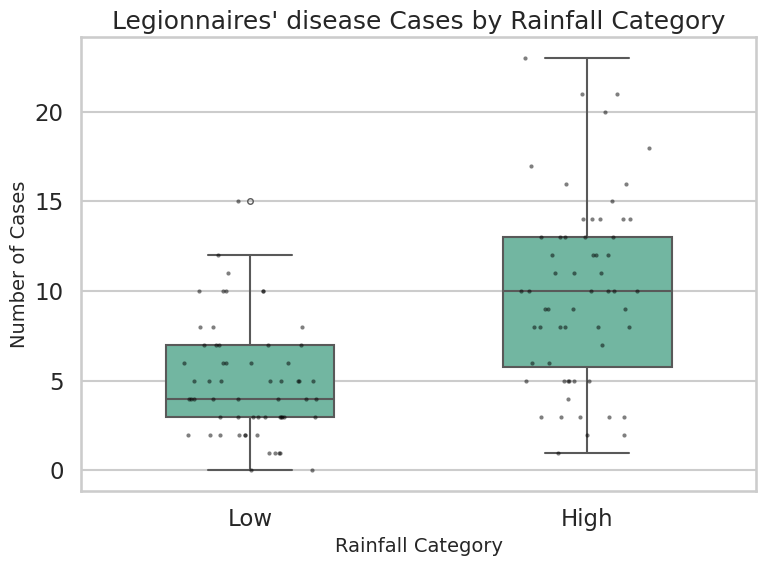

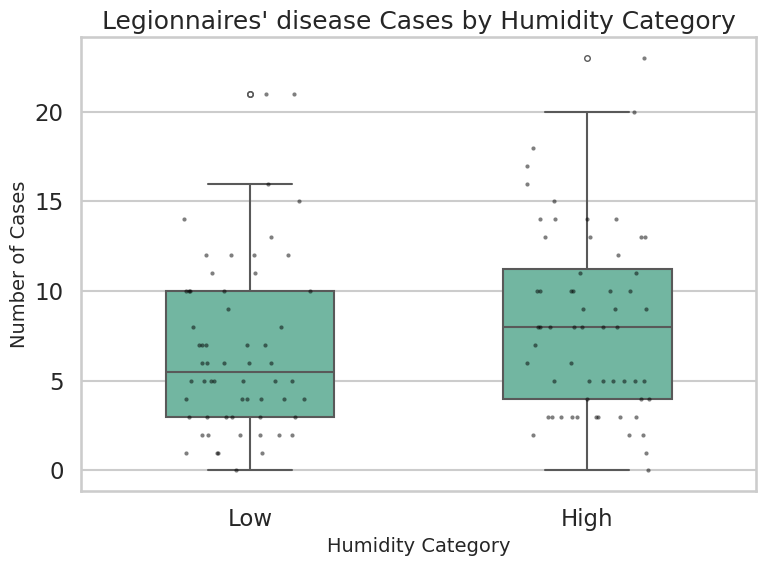

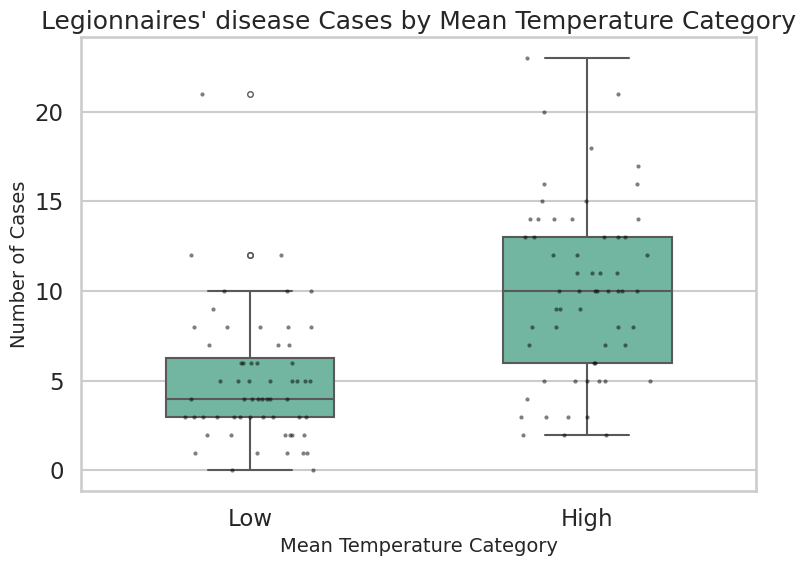

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Use Seaborn's built-in theme
sns.set(style="whitegrid", context="talk", palette="Set2")

def plot_boxplot(data, category_col, disease_col, variable_name):
    plt.figure(figsize=(8, 6))
    ax = sns.boxplot(
        x=category_col,
        y=disease_col,
        data=data,
        width=0.5,
        fliersize=4,
        linewidth=1.5
    )
    sns.stripplot(
        x=category_col,
        y=disease_col,
        data=data,
        color='black',
        alpha=0.5,
        jitter=0.2,
        size=3
    )
    plt.title(f'{disease_col} Cases by {variable_name} Category', fontsize=18)
    plt.xlabel(f'{variable_name} Category', fontsize=14)
    plt.ylabel('Number of Cases', fontsize=14)
    plt.tight_layout()
    plt.show()

# Rainfall boxplot
plot_boxplot(merged_htr, 'Rainfall_Category', "Legionnaires' disease", 'Rainfall')

# Humidity boxplot
plot_boxplot(merged_hth, 'Humidity_Category', "Legionnaires' disease", 'Humidity')

# Mean Temperature boxplot
plot_boxplot(merged_htt, 'Mean_Temp_Category', "Legionnaires' disease", 'Mean Temperature')


________________________________________________________________

### Decision Tree

In [22]:
# Data preparation
sf_median = merged["Legionnaires' disease"].median()
sf_X = merged[["Mean_Temp", "Rainfall"]]  # features

# Classify according to number of cases
merged["Legionnaires_Category"] = np.where(merged["Legionnaires' disease"] <= sf_median, "Low", "High")
sf_y = merged[["Legionnaires_Category"]]  # target

In [23]:
# Decision tree model
X_train, X_test, y_train, y_test = train_test_split(sf_X, sf_y, test_size=0.7, random_state=42, stratify=sf_y)
clf = DecisionTreeClassifier(random_state=42)
clf = clf.fit(X_train, y_train)

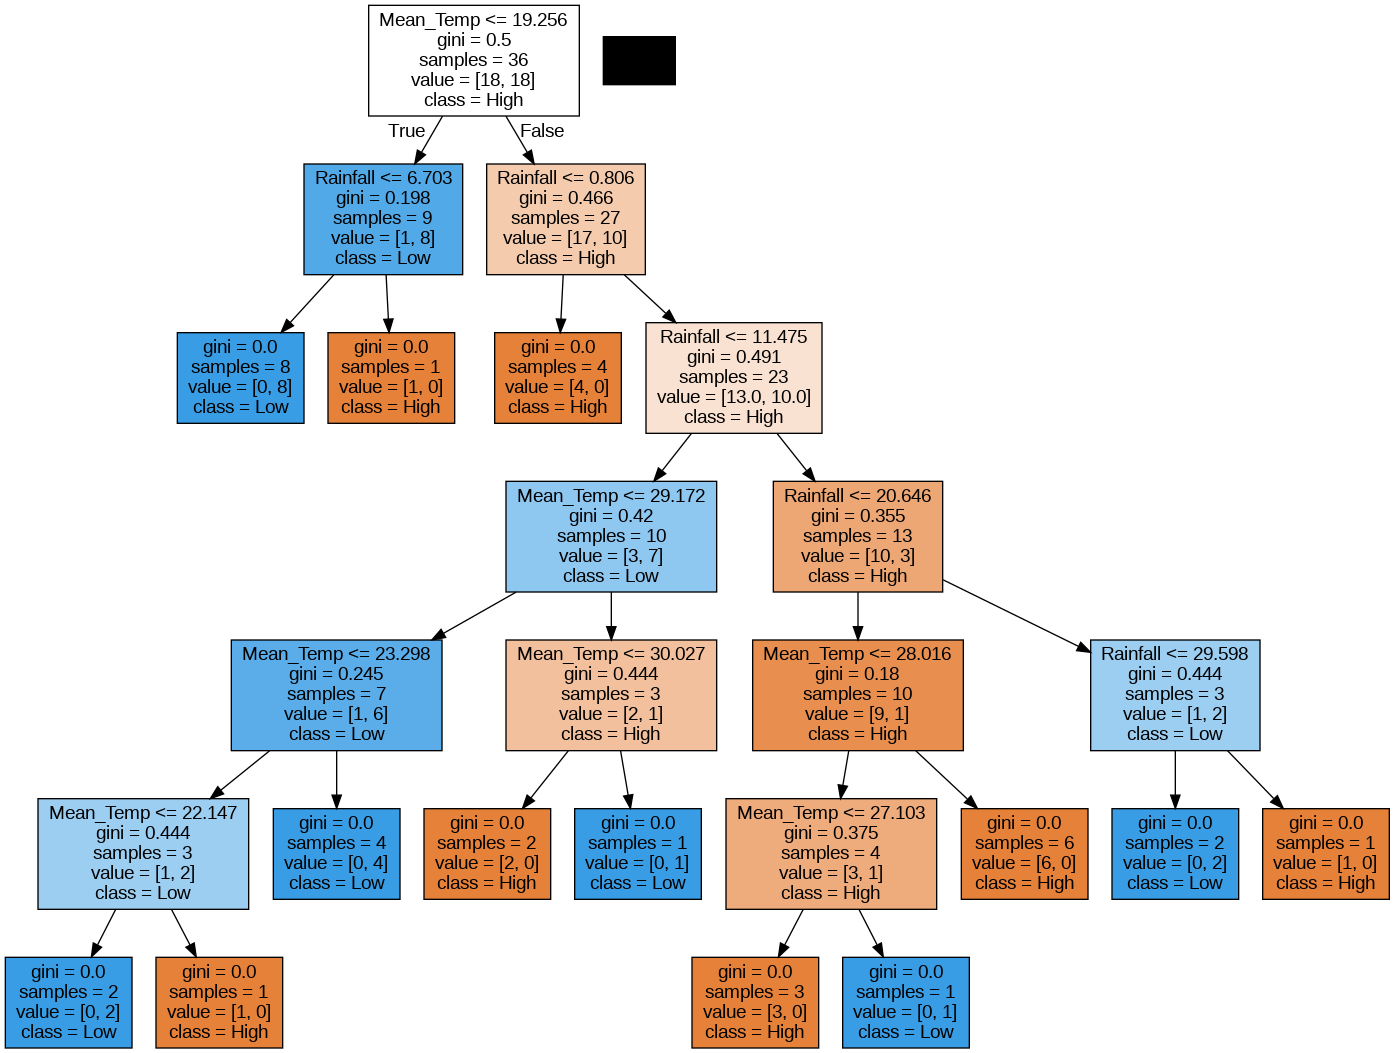

In [24]:
# Visualize the tree model
class_names = ["High", "Low"]

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, feature_names=sf_X.columns.tolist(), class_names=class_names)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

tree_image = Image(graph.create_png())
tree_image

In [25]:
# Accuracy
pred = clf.predict(X_test)
score = accuracy_score(y_test, pred)
print(score)

0.6071428571428571
